In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Initialize feature and target datasets
X = pd.read_csv(r"features.csv")
y = pd.read_csv(r"target.csv")

In [7]:
sample_size = 350  # Define sample size

# Merge X and Y to create full dataset
df = X
df['deposit'] = y

# Randomly select 350 records
sample_df, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df['deposit'],
    random_state=42
)

sample_df.shape  # Print shape to ensure that the sampling is correct

(350, 42)

In [8]:
sample_df['deposit'].value_counts(normalize=True)  # Print the ratio of target values

deposit
0    0.525714
1    0.474286
Name: proportion, dtype: float64

In [5]:
# Define new X and y variables
X = sample_df.drop('deposit', axis=1)
y = sample_df['deposit']

# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42, stratify=y, shuffle=True)

# Get features used to train the model
selector = SelectKBest(k=10).fit(X_train, y_train)
features_to_select = list(selector.get_feature_names_out())

# Add corresponding One Hot Encoded columns
corresponding_cols = ["contact_type_cellular", "contact_type_telephone", "poutcome_failure", "poutcome_other", "age_group_Elderly", "age_group_Young Adult"]
selected_features = [col for col in features_to_select]

for col in corresponding_cols:
    selected_features.append(col)
    
selected_features = set(selected_features) # Remove duplicate columns
selected_features = list(selected_features)  # Convert back into list
selected_features.sort()  # Sort columns in ascending order

# Select features in train and test set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

joblib.dump(selected_features, r"../MyAPI/pickled_objects/features.pkl")  # Dump features

print(f"The selected features are:\n{selected_features}")

The selected features are:
['age_group_Elderly', 'age_group_Middle Aged', 'age_group_Young Adult', 'campaign_contacts', 'contact_duration', 'contact_type_cellular', 'contact_type_telephone', 'contact_type_unknown', 'days_last_contacted', 'personal_loan_no', 'personal_loan_yes', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [6]:
# Create pipeline for feature selection and RF model
model = RandomForestClassifier(random_state=45)

# Grid Search best parameters for feature selector and model
param_grid = {
    'n_estimators': [20, 50, 100],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],          # Depth of each tree
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],         # Number of features to consider for best split
    'bootstrap': [True, False],               # Whether to use bootstrap samples
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print(f"The best parameters are:\n{best_params}")
print(f"\nThe best score is: {round(best_score, 2)}")

The best parameters are:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}

The best score is: 0.82


The model's accuracy is: 0.8

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        46
           1       0.77      0.81      0.79        42

    accuracy                           0.80        88
   macro avg       0.80      0.80      0.80        88
weighted avg       0.80      0.80      0.80        88



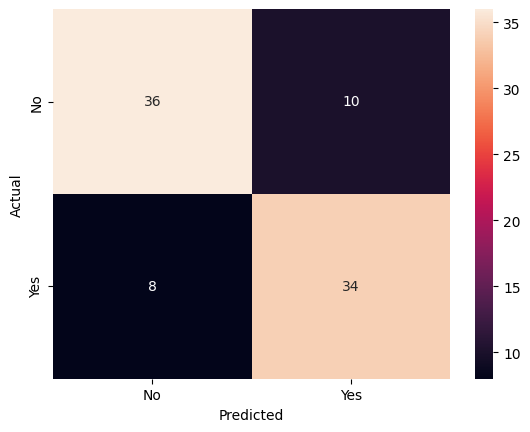

In [7]:
best_model = grid_search.best_estimator_  # Initialize the best model

y_pred = best_model.predict(X_test)  # Predict the test values
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

# Print the accuracy and classification report
print(f"The model's accuracy is: {round(accuracy, 2)}")
print()
print(classification_report(y_test, y_pred))

# Show confusion matrix
rf_matrix = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.heatmap(rf_matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['No', 'Yes']);ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [10]:
# Convert ints to float for Neural Network
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Create Sequential Model
clf_nn = Sequential([
    Input(shape=(15,)),
    Dense(units=200, activation='relu'),
    Dense(units=400, activation='relu'),
    Dropout(rate=0.1),
    Dense(units=5, activation='relu'),
    Dense(units=2, activation='softmax')
])

clf_nn.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
clf_nn.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=10, epochs=200, shuffle=True, verbose=2)

Epoch 1/200
24/24 - 1s - 38ms/step - accuracy: 0.5021 - loss: 1.0862 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 2/200
24/24 - 0s - 3ms/step - accuracy: 0.5277 - loss: 0.8608 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 3/200
24/24 - 0s - 2ms/step - accuracy: 0.5234 - loss: 0.6957 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 4/200
24/24 - 0s - 3ms/step - accuracy: 0.5404 - loss: 0.6862 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 5/200
24/24 - 0s - 3ms/step - accuracy: 0.5319 - loss: 0.6951 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 6/200
24/24 - 0s - 3ms/step - accuracy: 0.5277 - loss: 0.6929 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 7/200
24/24 - 0s - 3ms/step - accuracy: 0.5447 - loss: 0.6832 - val_accuracy: 0.5185 - val_loss: 0.6931
Epoch 8/200
24/24 - 0s - 3ms/step - accuracy: 0.5404 - loss: 0.6849 - val_accuracy: 0.5185 - val_loss: 0.6930
Epoch 9/200
24/24 - 0s - 2ms/step - accuracy: 0.5489 - loss: 0.6808 - val_accuracy: 0.4815 - val_loss: 0.6943
Epoch 10/

The Neural Network's accuracy score is: 0.51


Classification Report for the Neural Network:
              precision    recall  f1-score   support

           0       0.52      0.98      0.68        46
           1       0.00      0.00      0.00        42

    accuracy                           0.51        88
   macro avg       0.26      0.49      0.34        88
weighted avg       0.27      0.51      0.35        88



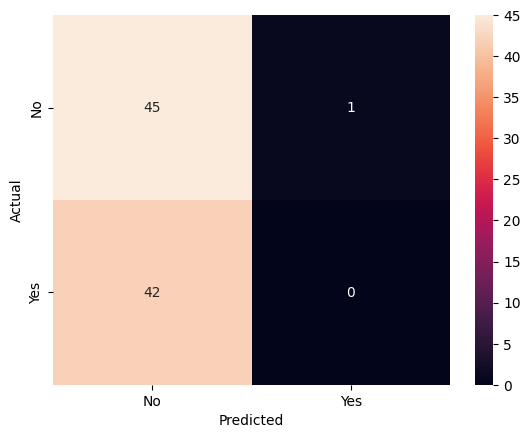

In [11]:
# Print the accuracy and classification report
predictions = clf_nn.predict(x=X_test, batch_size=10, verbose=0)
rounded_pred = np.argmax(predictions, axis=-1)
nn_accuracy = accuracy_score(y_true=y_test, y_pred=rounded_pred)
nn_clf_report = classification_report(y_true=y_test, y_pred=rounded_pred)

print(f"The Neural Network's accuracy score is: {round(nn_accuracy, 2)}\n")
print()
print(f"Classification Report for the Neural Network:\n{nn_clf_report}")

# Show confusion matrix
nn_matrix = confusion_matrix(y_test, rounded_pred)

ax = plt.subplot()
sns.heatmap(nn_matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['No', 'Yes']);ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [12]:
# Save models to directory
joblib.dump(best_model, r"../MyAPI/pickled_objects/rf_model.pkl")
joblib.dump(clf_nn, r"../MyAPI/pickled_objects/clf_nn.pkl")

['../MyAPI/pickled_objects/clf_nn.pkl']